# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

Загружаем необходимые библиотеки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (mean_absolute_error, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

Прочитаем датасеты.

In [ ]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Выведем на экран несколько строк итогового датасета.

In [ ]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Проверка правильности расчета эффективности обогащения.

Проверим правильность расчета эффективности обогащения в обучающей выборке. Вычислим её для признака rougher.output.recovery. <br/>


In [ ]:
df_train[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

Уберем пропуски в столбцах, необходимых для расчетов, из тренировочного датасета.

In [ ]:
df_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace=True)
df_train.shape

(14149, 87)

Вычислим эффективность обогащения.

In [ ]:
df_train['rougher.output.recovery.calculated'] = ((df_train['rougher.output.concentrate_au'] *
                       (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])) / 
                      (df_train['rougher.input.feed_au'] * 
                      (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))) * 100
df_train[['rougher.output.recovery', 'rougher.output.recovery.calculated']]

,rougher.output.recovery,rougher.output.recovery.calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


Найдем MAE между нашими расчётами и значением признака.

In [ ]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], df_train['rougher.output.recovery.calculated'])
mae.round(10)

0.0

Значение MAE стремится к 0, что говорит о правильности расчетов recovery и достоверности информации, удалим столбец с проверкой расчетов и продолжим обработку данных.

In [ ]:
df_train.drop('rougher.output.recovery.calculated', axis=1, inplace=True)

### Анализ признаков в тестовой и обучающей выборке.

Посмотрим какие столбцы есть в тренировочном сете, но нет в тестовом.

In [ ]:
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовом датасете у нас нет признаков .output на всех этапах очистки, так как это целевые признаки.

Так же в тестовом нет признаков calculation для этапа rougher, видимо эти данные рассчитываются позднее и не доступны во время процесса.

### Предобработка данных

Проверим есть ли дубликаты

In [ ]:
print(df_full.duplicated().sum())
print(df_test.duplicated().sum())
print(df_train.duplicated().sum())

0
0
0


Проверим есть ли в датасетах пропуски. 

In [ ]:
df_train.isna().sum() # проверяем тренировочный датасет

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

В условиях задачи сказано, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Поэтому заполним пропуски последним существующим значением выше пропущенного значения.

In [ ]:
df_train = df_train.fillna(method='ffill')
df_train.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

То же самое проделываем с тестовым и полным датасетом.

In [ ]:
df_test.isna().sum() # проверяем тестовый датасет

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [ ]:
df_test = df_test.fillna(method='ffill')
df_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [ ]:
df_full.isna().sum() # проверяем тестовый датасет

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [ ]:
df_full = df_full.fillna(method='ffill')
df_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

### Выводы:
В процессе подготовки и предобработки данных мы:
- Убедились в правильности расчета эффективности обогащения руды.
- Определили каких признаки отсутсвуют в тестовой выборке. 
- Заполнили пропуски в датасетах.

## Анализ данных

### Анализ концентрации металлов на различных этапах очистки руды.

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для удобства посмотрим распределение на графиках.

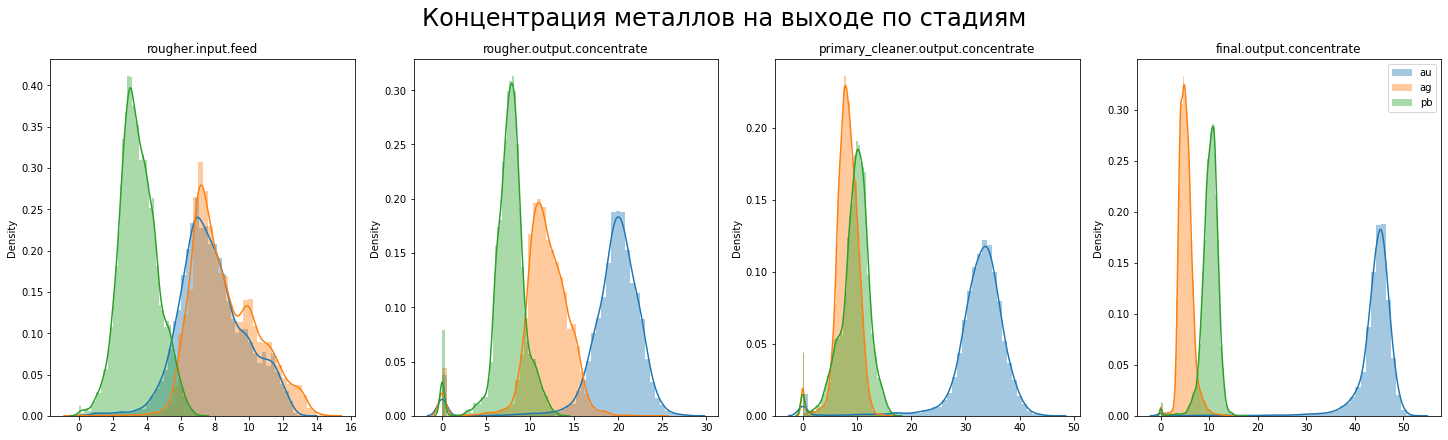

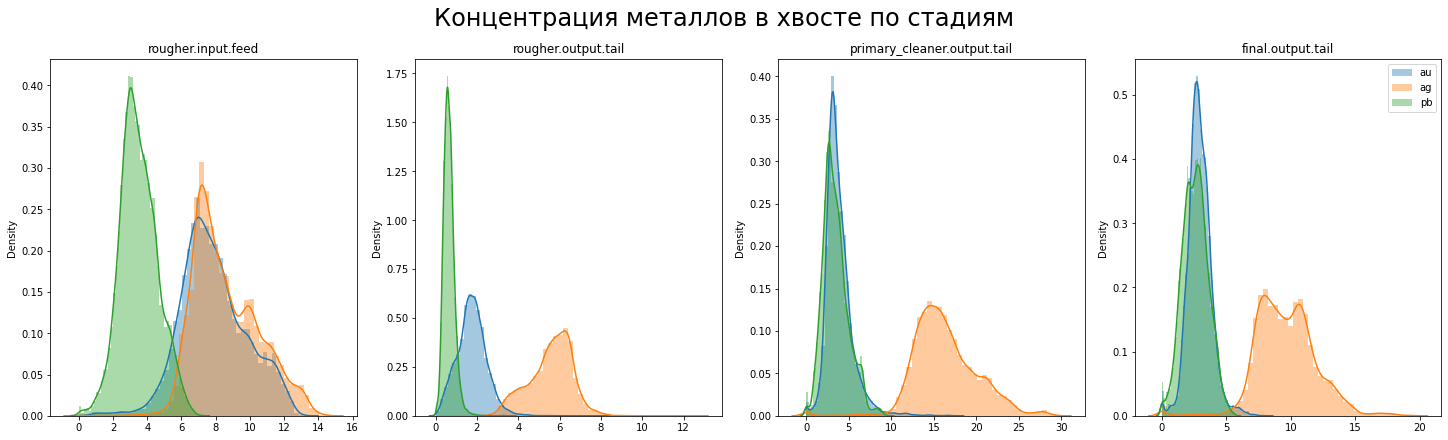

In [ ]:
# создадим список этапов очистки сырья по стадиям
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

# создадим список стадий формирования хвоста
process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

# создадим список с металлами.
metals = ['au', 'ag', 'pb']

# создадим оболочку для первого графика.
fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе по стадиям', fontsize=24)

# через цикл создадим графики распределения концентрации металлов на каждом этапе очистки.
for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

# создадим оболочку для второго графика
fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвосте по стадиям', fontsize=24)

# через цикл создадим графики распределения концентрации металлов в хвостах на каждом этапе очистки.
for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

1) Из графиков видно что в процессе очистики концентрация золота возрастает, отметим достаточно большое количетсво нулевых значений

2) Так же отмети различную концентрацию металлов в хвостовых отвалах в после различных этапов

Дополнительно посторим графики для концентрации каждого металла на разных процессах на выходе и в хвосте

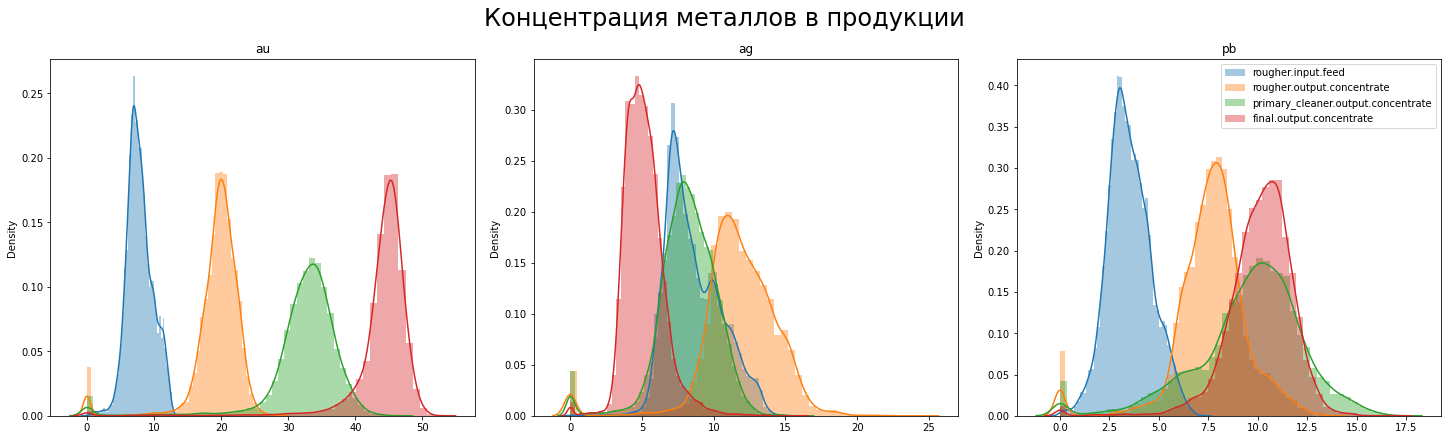

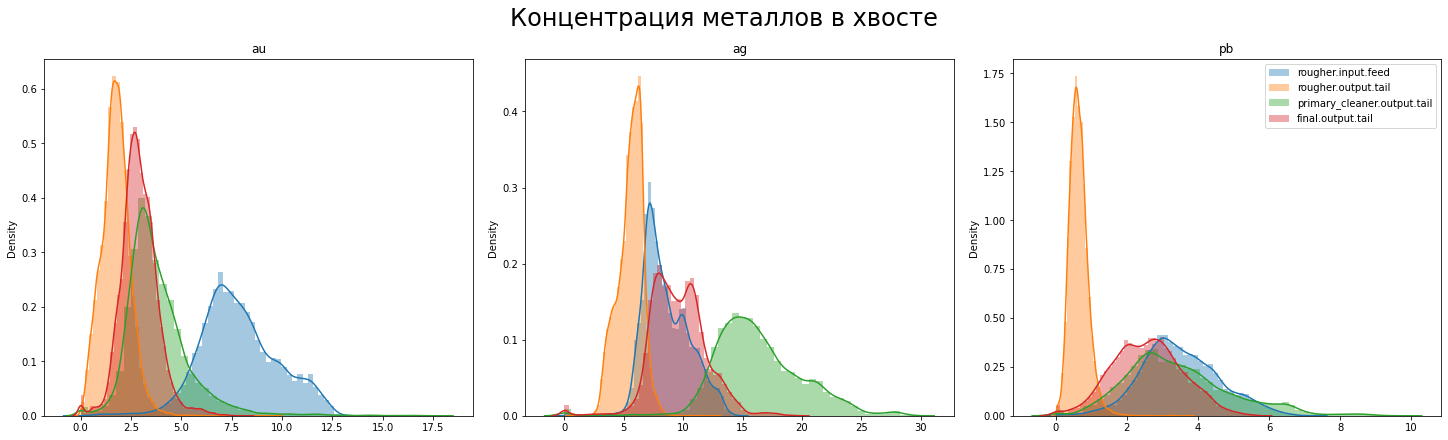

In [ ]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в продукции', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = df_train.columns.str.contains(stage + '_' + metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend() то

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвосте', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = df_train.columns.str.contains(stage + '_' + metal)
        sns_ax = sns.distplot(df_train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Отметим, что концентрация золота по мере очистки значительно вырастает, так же вырастают концентрации серебра и свинца за исключением последнего (финального этапа).

Самая большая концентрация золота в хвостах после флотации, при очистке концентрация золота в хвостах чуть меньше. Тоже самое характерно для других металлов.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

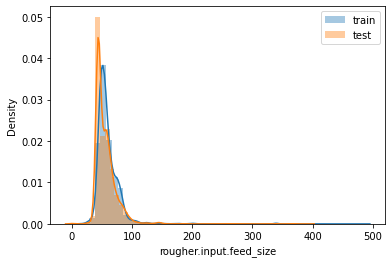

In [ ]:
sns.distplot(df_train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(df_test['rougher.input.feed_size'].dropna(), label='test')
plt.legend();

Как мы видим распределения очень похожи в выборках.

Рассмотрим распределение размера гранул перед первичной очисткой в тестовой и обучающей выборке.


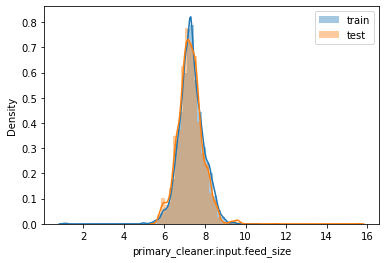

In [ ]:
sns.distplot(df_train['primary_cleaner.input.feed_size'].dropna(), label='train')
sns.distplot(df_test['primary_cleaner.input.feed_size'].dropna(), label='test')
plt.legend();

Распределение по выборкам похоже. Размер гранул существенно отличается от размера в черновом концентрате.

### Анализ суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Посчитаем суммарную концентрацию всех металлов на каждом этапе обогащения руды.

In [ ]:
# Считаем сумму концентраций металлов после флотации
df_full['sum_concentrate_rougher'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb'] + df_full['rougher.output.concentrate_sol'] + df_full['rougher.output.concentrate_au']

# Считаем сумму концентраций металлов после первичной очистки
df_full['sum_primary_cleaner_output_concentrate'] = df_full['primary_cleaner.output.concentrate_ag'] + df_full['primary_cleaner.output.concentrate_pb'] + df_full['primary_cleaner.output.concentrate_sol'] + df_full['primary_cleaner.output.concentrate_au']

# Считаем сумму концентраций металлов после финальной очистки
df_full['sum_final_output_concentrate'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb'] + df_full['final.output.concentrate_sol'] + df_full['final.output.concentrate_au']

sum_concentrate = ['sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate'] 

Отразим данные на графике.

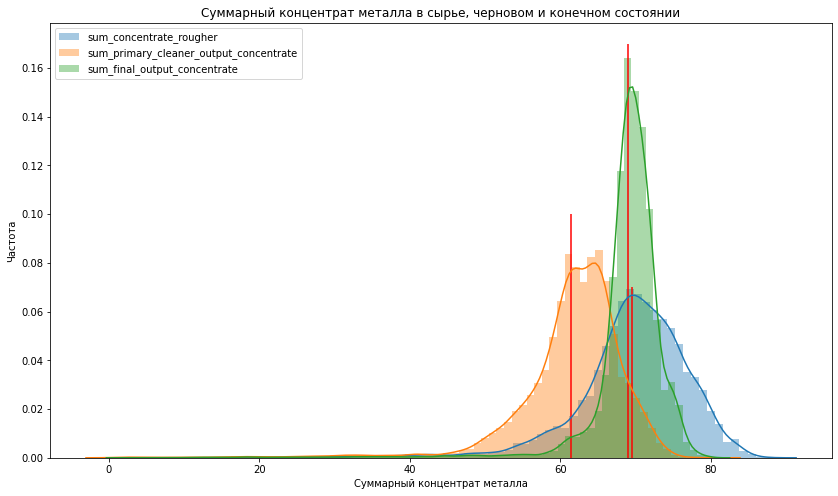

In [ ]:
plt.figure(figsize=(14,8))
sns.distplot(df_full[df_full['sum_concentrate_rougher']>0.04]['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(df_full[df_full['sum_primary_cleaner_output_concentrate']>0.04]['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(df_full[df_full['sum_final_output_concentrate']>0.04]['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(df_full[df_full['sum_concentrate_rougher']>0.3]['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(df_full[df_full['sum_primary_cleaner_output_concentrate']>0.3]['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(df_full[df_full['sum_final_output_concentrate']>0.3]['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Суммарный концентрат металла в сырье, черновом и конечном состоянии')
plt.xlabel("Суммарный концентрат металла")
plt.ylabel("Частота");

По распределению видно, что присутствуют выбросы. Есть много значению от 0 до 40, которые можно удалить. Удалим эти значения, чтобы не мешали обучению модели.

In [ ]:
df_full=df_full[df_full['sum_final_output_concentrate']>40]
df_full=df_full[df_full['sum_primary_cleaner_output_concentrate']>40]
df_full=df_full[df_full['sum_concentrate_rougher']>40]
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,sum_concentrate_rougher,sum_primary_cleaner_output_concentrate,sum_final_output_concentrate
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,67.012710,72.543485,63.957723
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,66.103793,72.095042,64.311180
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,65.752751,59.957723,63.573449
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,65.908382,71.321010,64.004667


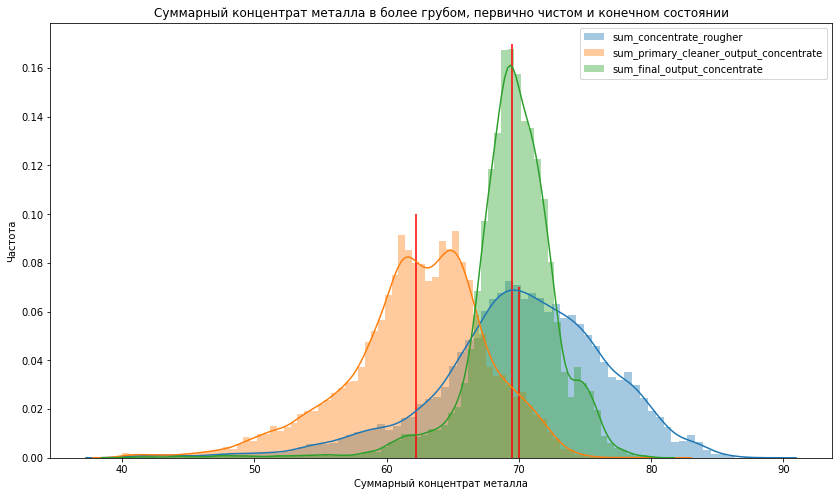

In [ ]:
plt.figure(figsize=(14,8))
sns.distplot(df_full['sum_concentrate_rougher'],bins=80,label='sum_concentrate_rougher')
sns.distplot(df_full['sum_primary_cleaner_output_concentrate'],bins=80,label='sum_primary_cleaner_output_concentrate')
sns.distplot(df_full['sum_final_output_concentrate'],bins=80,label='sum_final_output_concentrate')
plt.vlines(df_full['sum_concentrate_rougher'].mean(),0,0.07,color = 'r')
plt.vlines(df_full['sum_primary_cleaner_output_concentrate'].mean(),0,0.10,color = 'r')
plt.vlines(df_full['sum_final_output_concentrate'].mean(),0,0.17,color = 'r')
plt.legend()
plt.title('Суммарный концентрат металла в более грубом, первично чистом и конечном состоянии')
plt.xlabel("Суммарный концентрат металла")
plt.ylabel("Частота");

### Выводы:
- Концентрация золота и свинца растут с этапами очистки в разы, а концентрация серебра падает.
- Распределение гранул в тренировочном и тестовом датасете похоже. 
- После флотации суммарно концентрация металлов выросла в среднем в 2 раза, после финальных стадий очистки концентрация мтеллов выросла еще на 50. Распределение становиться ближе к среднему после каждго этапа очистки. 
- Убрали из данных выбросы, которые возможно возникли из-за технических проблем с оборудованием.

## Модель

### Функция расчета sMAPE.

Создадим функцию для расчета sMAPE. 

In [ ]:
def smape(target, predict):
    res = abs(target - predict) / (((abs(target) + abs(predict)) / 2))
    return res.sum() / len(res) * 100
 
def smape_final(smape_1, smape_2):
    return smape_1 * 0.25 + smape_2 * 0.75

### Подготовка данных.

Создаем переменные с признаками.

Поскольку предсказать нам нужно сразу 2 величины (эффективность обогащения чернового и финального концентрата), создадим 2 целевых признака. 

In [ ]:
# признаки для тренировочной выборки
features_train = df_train[df_test.columns].drop(['date'], axis=1) # для признаков истользуем только те столбцы, которые есть в тестовом датасете.
target_rougher_train = df_train['rougher.output.recovery'] # эффективность обогащения чернового концентрата. 
target_final_train = df_train['final.output.recovery'] # эффективность обогащения финального концентрата. 

В тестовой выборке не хватает признаков, добавим их из полного датасета, через функцию merge, объеденив данные через столбец date.

In [ ]:
# добавляем недостающие столбцы из исходного датасета.

df_test = df_test.merge(df_full[['date','rougher.output.recovery','final.output.recovery']], on=['date'], how='left')

df_test = df_test.dropna()

# признаки для тестовой выборки. На ней мы проверим окончательный результат обучения.
features_test = df_test.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)

# создаем целевые признаки для тестовой выборки.

target_rougher_test = df_test['rougher.output.recovery']
target_final_test = df_test['final.output.recovery']

Проведем масштабирование количественных признаков

In [ ]:
# создаем список со столбцами с количественными данными.
numeric = features_train.columns
# трансформируем данные
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None;
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.154580,0.377154,-0.117761,0.285633,-0.453621,-0.283904,-0.436246,-0.810391,-0.439519,-0.254349,...,-1.052891,-0.468787,-0.644461,-0.755839,-1.174433,-0.378783,-0.864572,-0.420943,-0.941197,-2.670558
1,-0.191516,0.426914,-0.117761,0.322644,-0.248048,-0.339722,-0.249235,-0.318234,-0.244963,-0.272554,...,-1.057226,-0.528215,-0.672889,-0.698327,-1.154951,-0.427866,-0.881034,-0.423780,-0.967738,-2.507288
2,-0.237204,0.729117,-0.117761,0.292305,-0.050275,-0.314313,-0.062837,-0.340312,-0.051233,-0.316207,...,-1.053212,-0.469435,-0.680072,-0.694960,-1.149521,-0.426788,-0.875983,-0.422132,-0.962479,-2.551516
3,-0.276332,0.730853,-0.117761,0.306874,-0.062640,-0.341034,-0.060758,-0.312616,-0.063891,-0.312218,...,-1.049417,-0.436647,-0.663562,-0.695985,-1.166762,-0.402310,-0.882323,-0.415458,-0.966489,-2.512923
4,-0.384454,0.906088,-0.117761,0.341826,-0.051961,-0.285677,-0.054819,-0.331845,-0.069271,-0.316714,...,-1.051043,-0.416569,-0.672406,-0.693609,-1.174420,-0.467895,-0.896733,-0.418012,-0.968033,-2.553386


Данные подготовлены к обучению, обучим несколько моделей и изучим их качество. Т.к. мы решаем задачу на регрессию, то воспользуемся моделями линейной регрессией, решающего дерева и случайного леса.

### Модель линейной регрессии.

Далее обучим модель линейной регрессии с крос валидацией, в которую в качестве параметра scoring зададим нашу функцию smape.

In [ ]:
# Обучаем модель для черной очистки
model_rougher_regres = LinearRegression()
# Оцениваем качество модели при помощи кросс-валидации. В качестве оценки используем sMAPE
scores_rougher_regres = cross_val_score(model_rougher_regres, features_train, target_rougher_train, cv=5, scoring=make_scorer(smape))
final_score_rougher_regres = scores_rougher_regres.mean()
print ('sMAPE чернового концентрата', final_score_rougher_regres)


# Обучаем модель для финальной очистки
model_final_regres = LinearRegression()
scores_final_regres = cross_val_score(model_final_regres, features_train, target_final_train, cv=5, scoring=make_scorer(smape))
final_score_final_regres = scores_final_regres.mean()
print ('sMAPE финального концентрата', final_score_final_regres)

# расчет итогового sMAPE
total_smape_final_regres = smape_final(final_score_rougher_regres, final_score_final_regres)
    
print('Итоговое sMAPE', total_smape_final_regres)

sMAPE чернового концентрата 12.80248345848199
sMAPE финального концентрата 12.245300320302249
Итоговое sMAPE 12.384596104847184


### Модель решающего дерева.

Обучаем модель для черновой очистки.

Выберем наилучшие параметры модели.

In [ ]:
#  объявляем классификатор TreeRegressor, не внося в него никаких параметров:
clf = DecisionTreeRegressor(random_state=1234)

# Отдельно создаем словарик, в который вписываем параметры, которые будем прогонять  
parametr = {'max_depth': range (1, 20)}

# Запускаем обучение
grid = GridSearchCV(clf, parametr, cv=5, scoring = make_scorer(smape, greater_is_better=False))
grid.fit(features_train, target_rougher_train)

# Выводим лучший результат
grid.best_params_

{'max_depth': 5}

Обучаем модель с наилучшим параментом и измереяем 

In [ ]:
model_rougher_tree = DecisionTreeRegressor(random_state=1234, max_depth=5)
score_rougher_tree = (cross_val_score(
    model_rougher_tree, features_train, target_rougher_train, cv = 5, scoring = make_scorer(smape))
                     ) 
final_score_rougher_tree = score_rougher_tree.mean()
print ('sMAPE чернового концентрата', final_score_rougher_tree)

sMAPE чернового концентрата 11.361153901326634


Выберем наилучшие параметры модели.

In [ ]:
clf = DecisionTreeRegressor(random_state=1234)
parametr = {'max_depth': range (1, 20)}
grid = GridSearchCV(clf, parametr, cv=5, scoring = make_scorer(smape, greater_is_better=False))
grid.fit(features_train, target_final_train)
grid.best_params_

{'max_depth': 3}

Обучаем модель с наилучшим параментом и измереяем 

In [ ]:
model_final_tree = DecisionTreeRegressor(random_state=1234, max_depth=3)
score_final_tree = (cross_val_score
                    (model_final_tree, features_train, target_final_train, cv = 5, scoring = make_scorer(smape)))
final_score_final_tree = score_final_tree.mean()
print ('sMAPE чернового концентрата', final_score_final_tree)

sMAPE чернового концентрата 10.806104806167749


Расчитываем итоговую sMAPE

In [ ]:
total_smape_final_tree = smape_final(final_score_rougher_tree, final_score_final_tree)
    
print('Итоговое sMAPE', total_smape_final_tree)

Итоговое sMAPE 10.944867079957469


### Модель случайного леса.

Выбираем наилучшие параметры

In [ ]:
clf = RandomForestRegressor(random_state=1234)
parametrs = { 'n_estimators': range (1, 10),
              'max_depth': range (1,10)
            }
grid = GridSearchCV(clf, parametrs, cv=5, scoring=make_scorer(smape, greater_is_better=False))
grid.fit(features_train, target_rougher_train)

grid.best_params_

{'max_depth': 3, 'n_estimators': 6}

Запускаем модель обучения с лучшими параметрами.

In [ ]:
model_rougher_forest = RandomForestRegressor(random_state=1234, max_depth=3, n_estimators=6)
score_rougher_forest = cross_val_score(model_rougher_forest, features_train, target_rougher_train, cv = 5, scoring = make_scorer(smape))
final_score_rougher_forest = score_rougher_forest.mean()
print ('sMAPE чернового концентрата', final_score_rougher_forest)

sMAPE чернового концентрата 11.37874972744462


Выбираем лучшие параметры

In [ ]:
clf = RandomForestRegressor(random_state=1234) 
parametrs = { 'n_estimators': range (1, 10),
              'max_depth': range (1,10)
            }
grid = GridSearchCV(clf, parametrs, cv=5, scoring=make_scorer(smape, greater_is_better=False))
grid.fit(features_train, target_final_train)
grid.best_params_

{'max_depth': 3, 'n_estimators': 8}

In [ ]:
model_final_forest = RandomForestRegressor(random_state=1234, max_depth=3, n_estimators=8)
score_final_forest = cross_val_score(model_final_forest, features_train, target_final_train, cv = 5, scoring = make_scorer(smape))
final_score_final_forest = score_final_forest.mean()
print ('sMAPE чернового концентрата', final_score_final_forest)

sMAPE чернового концентрата 10.339176345892488


Расчитываем итоговую sMAPE.

In [ ]:
total_smape_final_forest = smape_final(final_score_rougher_forest, final_score_final_forest)
    
print('Итоговое sMAPE', total_smape_final_forest)

Итоговое sMAPE 10.599069691280521


### Итоги.

Выведем итоговые sMAPE всех обученных моделей и определимся с лучшей.

In [ ]:
print('Итоговое sMAPE линейной регресии:', total_smape_final_regres)
print('Итоговое sMAPE решающего дерева:', total_smape_final_tree)
print('Итоговое sMAPE случайного леса:', total_smape_final_forest)

Итоговое sMAPE линейной регресии: 12.384596104847184
Итоговое sMAPE решающего дерева: 10.944867079957469
Итоговое sMAPE случайного леса: 10.599069691280521


Наилучшей моделью является модель Случайного леса. Проверим модель на тестовой выборке и оценим ее качество.

In [ ]:
# Обучим тренировочную выборку на лучшей моделе, предскажем результаты на тестовой выборке и расчитаем sMAPE.

# Для чернового этапа
model_total_rougher = (RandomForestRegressor(random_state=1234, max_depth=3, n_estimators=6)
                       .fit(features_train, target_rougher_train))
predictions_test_rougher = model_total_rougher.predict(features_test)
smape_test_rougher = smape(target_rougher_test, predictions_test_rougher)
print(smape_test_rougher)
                       
# Для финального этапа
model_total_final = (RandomForestRegressor(random_state=1234, max_depth=3, n_estimators=8)
                       .fit(features_train, target_final_train))
predictions_test_final = model_total_final.predict(features_test)
smape_test_final = smape(target_final_test, predictions_test_final)
print(smape_test_final)                    

# Считаем итоговый sMAPE и выводим результаты по моделям
total_smape_test = smape_final(smape_test_rougher, smape_test_final)
print('Итоговое sMAPE на тестовой выборке', total_smape_test)

7.356791901706316
7.704647945067165
Итоговое sMAPE на тестовой выборке 7.617683934226953


### Проверка на адекватность

Проверим модель на адекватность. Сравним насколько наша модель предсказывает лучше, чем просто среднее значение целевого признака. 

In [ ]:
# черновой этап
dummy_rougher = DummyRegressor(strategy='mean').fit(features_train, target_rougher_train)
dummy_pred_rougher = dummy_rougher.predict(features_test)
dummy_smape_rougher = smape(target_rougher_test, dummy_pred_rougher)
print(dummy_smape_rougher)

# финальный этап очистки
dummy_final = DummyRegressor(strategy='mean').fit(features_train, target_final_train)
dummy_pred_final = dummy_final.predict(features_test)
dummy_smape_final = smape(target_final_test, dummy_pred_final)
print(dummy_smape_final)

# итоговый sMAPE
total_smape_dummy = smape_final(dummy_smape_rougher, dummy_smape_final)
print('Итоговое sMAPE dummy', total_smape_dummy)

6.508311262991199
8.512622101140856
Итоговое sMAPE dummy 8.011544391603442


Наша модель предсказывает коэффициент в черновом концентрате хуже, чем среднее значение, а в финальном концентрате лучше. 

### Выводы: 
В результате проделанной работы был подготовлен прототип модели машинного обучения для компании «Цифра». Модель предсказывает коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство золотодобывающей компании. <br/>

При работе над проектом использовали три датасета, которые предварительно обработали (проверили правильность расчетов и заполнили пропуски). <br/>
В процессе <b>анализа данных</b> рассмотрели как меняется концентрация металлов (по отдельности и в сумме) на различных этапах очистки. А также убедились, что распределение размеров гранул сырья в обучающей и тестовой выборке существенно не отличается.<br/>
<b>Перед обучением модели</b> была проделана следующая работа:
 - создана функции для определения качества модели;
 - добавлены в тестовый датасет недостающие данные из исходного датасета;
 - разбиты данные тренировочной и тестовой выборки на признаки и целевой признак;
 - выбрана наилучшая модель машинного обучения.
 
Качество наилучшей модели мы сравнили с базовой моделью (в качестве предсказания использовали среднее значение целевого признака). В результате сравнения обнаружили, что модель предсказывает коэффициент восстановления золота в черновом концентрате хуже чем, базовая модель. Этот вывод огорчает. Необходимо поработать еще над качеством модели.
